# Notebook 4: Sensitivity Check

In [62]:
%load_ext autoreload
%autoreload 2

#import time
import pickle
import numpy as np
#from scipy import optimize
from datetime import datetime
import pandas as pd
import urllib.request
from fredapi import Fred
from sklearn.metrics import auc

import time
import numpy as np
from scipy import optimize

from consav.grids import equilogspace
from consav.markov import log_rouwenhorst
from consav.misc import elapsed
import matplotlib.pyplot as plt   

plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.rcParams.update({'font.size': 12})

import matplotlib.pyplot as plt   
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from consav.markov import tauchen, find_ergodic

from HANKSAMModel import HANKSAMModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
model = HANKSAMModelClass(name='baseline')

In [61]:
par = model.par
ss = model.ss
path = model.path
ini = model.ini

## Check, that the code works

In [24]:
# Set UI system
par.UI_ratio_high = 0.83
par.UI_ratio_low = 0.54
par.UI_duration = 6.0

In [17]:
model.find_ss(do_print=True)

Guess on L of: -0.05 causes diff L_guess - L_endo of: -0.09492529098253259
Guess on L of: 0.1 causes diff L_guess - L_endo of: 0.05958046485777733
Guess on L of: 0.042157043405531475 causes diff L_guess - L_endo of: 5.311121343168357e-05
Guess on L of: 0.04210546389586954 causes diff L_guess - L_endo of: 3.5655290386849003e-09
Guess on L of: 0.04210545868534222 causes diff L_guess - L_endo of: -1.7993794718118572e-09


## Define functions

In [27]:
def gini(ss, par):
    
    D_new = np.sum(ss.D, axis = 0)
    
    # a. income
    inc_emp = par.a_grid*(ss.RealR-1) + ss.w*(1-par.tau) + ss.L
    inc_high = par.a_grid*(ss.RealR-1) + ss.w*(1-par.tau)*par.UI_ratio_high + ss.L 
    inc_low = par.a_grid*(ss.RealR-1) + ss.w*(1-par.tau)*par.UI_ratio_low + ss.L 
    
    #Distribution
    D_h = np.zeros((par.Na))
    D_l = np.zeros((par.Na))

    for i_a in range(par.Na):
        for i_z in range(par.Nz):
            if 0 < i_z < par.UI_duration + 1:
                D_h[i_a] += D_new[i_z,i_a] 
            elif i_z > par.UI_duration:
                D_l[i_a] += D_new[i_z,i_a]
    
    # Gini, total economy
    inc = np.concatenate((inc_low, inc_high, inc_emp))

    D_inc = np.concatenate((D_l, D_h, D_new[0]))

    inc_s, D_s = zip(*sorted(zip(inc, D_inc)))

    inc_s = tuple(ele1 * ele2 for ele1, ele2 in zip(inc_s, D_s))
    
    # Get Cumulative distribution
    x = np.insert(np.cumsum(D_s),0,0.0) 

    y_noscale = np.cumsum(inc_s)
    y = np.insert(y_noscale/y_noscale[-1],0,0.0)
    
    # calculate gini
    gini = (auc(y,y) - auc(x,y)) / auc(y,y)    
    
    return x, y, gini

# Sensitivity check

In [29]:
# Calculate at initial parametrization

UI_ratio_vec = np.linspace(0.54, 1.1, 29)

# Search
S_UI = np.nan + np.zeros(len(UI_ratio_vec))
S_UI_pol = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))
s_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
s_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
s_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

#savings 
A_UI_pol = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))

a_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
a_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

# Consumption
C_UI = np.nan + np.zeros(len(UI_ratio_vec))
c_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
c_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
c_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

# Unemployment rates
u_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))
    
# Long term unemployed
u_UI_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_UI_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_UI_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
u_UI_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

#ut unemployed
ut_UI = np.nan + np.zeros(len(UI_ratio_vec))
ut_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
ut_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
ut_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

#Unemployment fractions
frac_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
frac_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
frac_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

fracl_htm_UI = np.nan + np.zeros(len(UI_ratio_vec))
fracl_im_UI = np.nan + np.zeros(len(UI_ratio_vec))
fracl_pat_UI = np.nan + np.zeros(len(UI_ratio_vec))

# Other aggregates
betashare_UI = np.nan + np.zeros((len(UI_ratio_vec), len(par.beta_grid)))
V_UI = np.nan + np.zeros((len(UI_ratio_vec), len(par.beta_grid)))
L_UI = np.nan + np.zeros(len(UI_ratio_vec))
lambda_u_UI = np.nan + np.zeros(len(UI_ratio_vec))

# for fractiles
D_f = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))
V_f = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))

Dbeg_UI = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))

# Gini
gini_UI = np.nan + np.zeros(len(UI_ratio_vec))

for i in range(len(UI_ratio_vec)):
    par.UI_ratio_high = UI_ratio_vec[i]
    print(par.UI_ratio_high)
    model.find_ss()
    
    # Search
    S_UI[i] = ss.S_hh
    S_UI_pol[i] = ss.s
    Dbeg_UI[i] = ss.Dbeg 
    
    s_htm_UI[i] = np.sum(ss.s[0]*ss.D[0]) / np.sum(ss.D[0])
    s_im_UI[i] = np.sum(ss.s[1]*ss.D[1]) / np.sum(ss.D[1])
    s_pat_UI[i] = np.sum(ss.s[2]*ss.D[2]) / np.sum(ss.D[2])
    
    #savings 
    A_UI_pol[i] = ss.a
    
    a_im_UI[i] = np.sum(ss.a[1]*ss.D[1]) / np.sum(ss.D[1])
    a_pat_UI[i] = np.sum(ss.a[2]*ss.D[2]) / np.sum(ss.D[2])
    
    # Consumption
    C_UI[i] = ss.C_hh
    
    c_htm_UI[i] = np.sum(ss.c[0]*ss.D[0]) / np.sum(ss.D[0])
    c_im_UI[i] = np.sum(ss.c[1]*ss.D[1]) / np.sum(ss.D[1])
    c_pat_UI[i] = np.sum(ss.c[2]*ss.D[2]) / np.sum(ss.D[2])
    
    # unemployment rates
    u_UI[i] = ss.u
    
    u_htm_UI[i] = np.sum(ss.D[0,1:]) / np.sum(ss.D[0])
    u_im_UI[i] = np.sum(ss.D[1,1:]) / np.sum(ss.D[1])
    u_pat_UI[i] = np.sum(ss.D[2,1:]) / np.sum(ss.D[2])
    
    # Long term unemployed
    u_UI_UI[i] = ss.U_UI_hh
    
    u_UI_htm_UI[i] = np.sum(ss.u_UI[0]*ss.D[0]) / np.sum(ss.D[0])
    u_UI_im_UI[i] = np.sum(ss.u_UI[1]*ss.D[1]) / np.sum(ss.D[1])
    u_UI_pat_UI[i] = np.sum(ss.u_UI[2]*ss.D[2]) / np.sum(ss.D[2])
    
    #ut unemployed
    ut_UI[i] = ss.ut
    
    ut_htm_UI[i] = (ss.delta*np.sum(ss.D[0,0]) + np.sum(ss.D[0,1:]))  / np.sum(ss.D[0])
    ut_im_UI[i] = (ss.delta*np.sum(ss.D[1,0]) + np.sum(ss.D[1,1:])) / np.sum(ss.D[1])
    ut_pat_UI[i] = (ss.delta*np.sum(ss.D[2,0]) + np.sum(ss.D[2,1:])) / np.sum(ss.D[2])
    
    #Fractions of total unemployment
    frac_htm_UI[i] = np.sum(ss.D[0,1:]) / np.sum(ss.D[0])
    frac_im_UI[i] = np.sum(ss.D[1,1:]) / np.sum(ss.D[1])
    frac_pat_UI[i] = np.sum(ss.D[2,1:]) / np.sum(ss.D[2])

    fracl_htm_UI[i] = np.sum(ss.D[0,7:]) / np.sum(ss.D[0])
    fracl_im_UI[i] = np.sum(ss.D[1,7:]) / np.sum(ss.D[1])
    fracl_pat_UI[i] = np.sum(ss.D[2,7:]) / np.sum(ss.D[2])
    
    #Other aggregates
    L_UI[i] = ss.L
    betashare_UI[i] = [par.HtM_share, 1-par.PIH_share-par.HtM_share, par.PIH_share] 
    V_UI[i] = [ np.sum(ss.D[0]*ss.V[0]) / np.sum(ss.D[0]), np.sum(ss.D[1]*ss.V[1]) / np.sum(ss.D[1]), np.sum(ss.D[2]*ss.V[2]) / np.sum(ss.D[2]) ]  
    lambda_u_UI[i] = ss.lambda_u
    
    # For fractiles
    V_f[i] = ss.V
    D_f[i] = ss.D
    
    # For gini
    if np.min(ss.D) < 0:
        gini_UI[i] = 0.0
    else:
        _, _, gini_UI[i] = gini(ss,par)

0.54
0.56
0.5800000000000001
0.6000000000000001
0.62
0.64
0.66
0.68
0.7000000000000001
0.72
0.74
0.76
0.78
0.8
0.8200000000000001
0.8400000000000001
0.8600000000000001
0.8800000000000001
0.9
0.92
0.9400000000000001
0.96
0.98
1.0
1.02
1.04
1.06
1.08
1.1


In [30]:
# Set new parameters

f = 1.02

par.HtM_share = par.HtM_share*f
par.beta_firm = par.beta_firm*f

par.sigma = par.sigma*f
par.nu = par.nu*f
par.varphi = par.varphi*f

par.delta_ss = par.delta_ss*f
par.lambda_u_s_ss = par.lambda_u_s_ss*f
par.theta_ss = par.theta_ss*f
par.alpha = par.alpha*f 

par.w_ss = par.w_ss*f 
par.kappa_0 =par.kappa_0*f
par.psi = par.psi*f
par.xi = par.xi*f
par.p_fac = par.p_fac*f 


# final goods firms
par.epsilon_p = par.epsilon_p*f     
par.phi = par.phi*f
        
# monetary policy
par.delta_pi = par.delta_pi*f
par.R_ss = 1.022

par.qB_share_ss = par.qB_share_ss*f
        
par.tau = par.tau*f
        

In [31]:
#Calculate steady state for new parameters
UI_ratio_vec = np.linspace(0.54, 1.1, 29)

# Search
S_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
S_UI_pol_upper = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))
s_htm_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
s_im_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
s_pat_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))

#savings 
A_UI_pol_upper = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))

a_im_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
a_pat_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))

# Consumption
C_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
c_htm_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
c_im_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
c_pat_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))

# Unemployment rates
u_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
u_htm_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
u_im_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
u_pat_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
    
# Long term unemployed
u_UI_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
u_UI_htm_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
u_UI_im_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
u_UI_pat_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))

#ut unemployed
ut_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
ut_htm_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
ut_im_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
ut_pat_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))

#Unemployment fractions
frac_htm_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
frac_im_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
frac_pat_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))

fracl_htm_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
fracl_im_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
fracl_pat_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))

# Other aggregates
betashare_UI_upper = np.nan + np.zeros((len(UI_ratio_vec), len(par.beta_grid)))
V_UI_upper = np.nan + np.zeros((len(UI_ratio_vec), len(par.beta_grid)))
L_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))
lambda_u_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))

# for fractiles
D_f_upper = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))
V_f_upper = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))

Dbeg_UI_upper = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))

# Gini
gini_UI_upper = np.nan + np.zeros(len(UI_ratio_vec))

for i in range(len(UI_ratio_vec)):
    par.UI_ratio_high = UI_ratio_vec[i]
    print(par.UI_ratio_high)
    model.find_ss()
    
    # Search
    S_UI_upper[i] = ss.S_hh
    S_UI_pol_upper[i] = ss.s
    Dbeg_UI_upper[i] = ss.Dbeg 
    
    s_htm_UI_upper[i] = np.sum(ss.s[0]*ss.D[0]) / np.sum(ss.D[0])
    s_im_UI_upper[i] = np.sum(ss.s[1]*ss.D[1]) / np.sum(ss.D[1])
    s_pat_UI_upper[i] = np.sum(ss.s[2]*ss.D[2]) / np.sum(ss.D[2])
    
    #savings 
    A_UI_pol_upper[i] = ss.a
    
    a_im_UI_upper[i] = np.sum(ss.a[1]*ss.D[1]) / np.sum(ss.D[1])
    a_pat_UI_upper[i] = np.sum(ss.a[2]*ss.D[2]) / np.sum(ss.D[2])
    
    # Consumption
    C_UI_upper[i] = ss.C_hh
    
    c_htm_UI_upper[i] = np.sum(ss.c[0]*ss.D[0]) / np.sum(ss.D[0])
    c_im_UI_upper[i] = np.sum(ss.c[1]*ss.D[1]) / np.sum(ss.D[1])
    c_pat_UI_upper[i] = np.sum(ss.c[2]*ss.D[2]) / np.sum(ss.D[2])
    
    # unemployment rates
    u_UI_upper[i] = ss.u
    
    u_htm_UI_upper[i] = np.sum(ss.D[0,1:]) / np.sum(ss.D[0])
    u_im_UI_upper[i] = np.sum(ss.D[1,1:]) / np.sum(ss.D[1])
    u_pat_UI_upper[i] = np.sum(ss.D[2,1:]) / np.sum(ss.D[2])
    
    # Long term unemployed
    u_UI_UI_upper[i] = ss.U_UI_hh
    
    u_UI_htm_UI_upper[i] = np.sum(ss.u_UI[0]*ss.D[0]) / np.sum(ss.D[0])
    u_UI_im_UI_upper[i] = np.sum(ss.u_UI[1]*ss.D[1]) / np.sum(ss.D[1])
    u_UI_pat_UI_upper[i] = np.sum(ss.u_UI[2]*ss.D[2]) / np.sum(ss.D[2])
    
    #ut unemployed
    ut_UI_upper[i] = ss.ut
    
    ut_htm_UI_upper[i] = (ss.delta*np.sum(ss.D[0,0]) + np.sum(ss.D[0,1:]))  / np.sum(ss.D[0])
    ut_im_UI_upper[i] = (ss.delta*np.sum(ss.D[1,0]) + np.sum(ss.D[1,1:])) / np.sum(ss.D[1])
    ut_pat_UI_upper[i] = (ss.delta*np.sum(ss.D[2,0]) + np.sum(ss.D[2,1:])) / np.sum(ss.D[2])
    
    #Fractions of total unemployment
    frac_htm_UI_upper[i] = np.sum(ss.D[0,1:]) / np.sum(ss.D[0])
    frac_im_UI_upper[i] = np.sum(ss.D[1,1:]) / np.sum(ss.D[1])
    frac_pat_UI_upper[i] = np.sum(ss.D[2,1:]) / np.sum(ss.D[2])

    fracl_htm_UI_upper[i] = np.sum(ss.D[0,7:]) / np.sum(ss.D[0])
    fracl_im_UI_upper[i] = np.sum(ss.D[1,7:]) / np.sum(ss.D[1])
    fracl_pat_UI_upper[i] = np.sum(ss.D[2,7:]) / np.sum(ss.D[2])
    
    #Other aggregates
    L_UI_upper[i] = ss.L
    betashare_UI_upper[i] = [par.HtM_share, 1-par.PIH_share-par.HtM_share, par.PIH_share] 
    V_UI_upper[i] = [ np.sum(ss.D[0]*ss.V[0]) / np.sum(ss.D[0]), np.sum(ss.D[1]*ss.V[1]) / np.sum(ss.D[1]), np.sum(ss.D[2]*ss.V[2]) / np.sum(ss.D[2]) ]  
    lambda_u_UI_upper[i] = ss.lambda_u
    
    # For fractiles
    V_f_upper[i] = ss.V
    D_f_upper[i] = ss.D
    
    # For gini
    if np.min(ss.D) < 0:
        gini_UI_upper[i] = 0.0
    else:
        _, _, gini_UI_upper[i] = gini(ss,par)

0.54
0.56
0.5800000000000001
0.6000000000000001
0.62
0.64
0.66
0.68
0.7000000000000001
0.72
0.74
0.76
0.78
0.8
0.8200000000000001
0.8400000000000001
0.8600000000000001
0.8800000000000001
0.9
0.92
0.9400000000000001
0.96
0.98
1.0
1.02
1.04
1.06
1.08
1.1


In [32]:
# Set new parameters

f = 0.98 /1.02

par.HtM_share = par.HtM_share*f
        
par.beta_firm = par.beta_firm*f

par.sigma = par.sigma*f
par.nu = par.nu*f
par.varphi = par.varphi*f

par.delta_ss = par.delta_ss*f
par.lambda_u_s_ss = par.lambda_u_s_ss*f
par.theta_ss = par.theta_ss*f
par.alpha = par.alpha*f 

par.w_ss = par.w_ss*f 
par.kappa_0 =par.kappa_0*f
par.psi = par.psi*f
par.xi = par.xi*f
par.p_fac = par.p_fac*f 


# final goods firms
par.epsilon_p = par.epsilon_p*f     
par.phi = par.phi*f
        
# monetary policy
par.delta_pi = par.delta_pi*f

par.R_ss = 1.0196

par.qB_share_ss = par.qB_share_ss*f
        
par.tau = par.tau*f
        
par.ela_phi_rath = par.ela_phi_rath*f

In [33]:
# Calculate for new parametes

UI_ratio_vec = np.linspace(0.54, 1.1, 29)

# Search
S_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
S_UI_pol_lower = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))
s_htm_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
s_im_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
s_pat_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))

#savings 
A_UI_pol_lower = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))

a_im_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
a_pat_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))

# Consumption
C_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
c_htm_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
c_im_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
c_pat_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))

# Unemployment rates
u_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
u_htm_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
u_im_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
u_pat_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
    
# Long term unemployed
u_UI_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
u_UI_htm_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
u_UI_im_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
u_UI_pat_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))

#ut unemployed
ut_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
ut_htm_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
ut_im_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
ut_pat_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))

#Unemployment fractions
frac_htm_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
frac_im_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
frac_pat_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))

fracl_htm_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
fracl_im_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
fracl_pat_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))

# Other aggregates
betashare_UI_lower = np.nan + np.zeros((len(UI_ratio_vec), len(par.beta_grid)))
V_UI_lower = np.nan + np.zeros((len(UI_ratio_vec), len(par.beta_grid)))
L_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))
lambda_u_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))

# for fractiles
D_f_lower = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))
V_f_lower = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))

Dbeg_UI_lower = np.nan + np.zeros((len(UI_ratio_vec), par.Nfix, par.Nz, par.Na))

# Gini
gini_UI_lower = np.nan + np.zeros(len(UI_ratio_vec))

for i in range(len(UI_ratio_vec)):
    par.UI_ratio_high = UI_ratio_vec[i]
    print(par.UI_ratio_high)
    model.find_ss()
    
    # Search
    S_UI_lower[i] = ss.S_hh
    S_UI_pol_lower[i] = ss.s
    Dbeg_UI_lower[i] = ss.Dbeg 
    
    s_htm_UI_lower[i] = np.sum(ss.s[0]*ss.D[0]) / np.sum(ss.D[0])
    s_im_UI_lower[i] = np.sum(ss.s[1]*ss.D[1]) / np.sum(ss.D[1])
    s_pat_UI_lower[i] = np.sum(ss.s[2]*ss.D[2]) / np.sum(ss.D[2])
    
    #savings 
    A_UI_pol_lower[i] = ss.a
    
    a_im_UI_lower[i] = np.sum(ss.a[1]*ss.D[1]) / np.sum(ss.D[1])
    a_pat_UI_lower[i] = np.sum(ss.a[2]*ss.D[2]) / np.sum(ss.D[2])
    
    # Consumption
    C_UI_lower[i] = ss.C_hh
    
    c_htm_UI_lower[i] = np.sum(ss.c[0]*ss.D[0]) / np.sum(ss.D[0])
    c_im_UI_lower[i] = np.sum(ss.c[1]*ss.D[1]) / np.sum(ss.D[1])
    c_pat_UI_lower[i] = np.sum(ss.c[2]*ss.D[2]) / np.sum(ss.D[2])
    
    # unemployment rates
    u_UI_lower[i] = ss.u
    
    u_htm_UI_lower[i] = np.sum(ss.D[0,1:]) / np.sum(ss.D[0])
    u_im_UI_lower[i] = np.sum(ss.D[1,1:]) / np.sum(ss.D[1])
    u_pat_UI_lower[i] = np.sum(ss.D[2,1:]) / np.sum(ss.D[2])
    
    # Long term unemployed
    u_UI_UI_lower[i] = ss.U_UI_hh
    
    u_UI_htm_UI_lower[i] = np.sum(ss.u_UI[0]*ss.D[0]) / np.sum(ss.D[0])
    u_UI_im_UI_lower[i] = np.sum(ss.u_UI[1]*ss.D[1]) / np.sum(ss.D[1])
    u_UI_pat_UI_lower[i] = np.sum(ss.u_UI[2]*ss.D[2]) / np.sum(ss.D[2])
    
    #ut unemployed
    ut_UI_lower[i] = ss.ut
    
    ut_htm_UI_lower[i] = (ss.delta*np.sum(ss.D[0,0]) + np.sum(ss.D[0,1:]))  / np.sum(ss.D[0])
    ut_im_UI_lower[i] = (ss.delta*np.sum(ss.D[1,0]) + np.sum(ss.D[1,1:])) / np.sum(ss.D[1])
    ut_pat_UI_lower[i] = (ss.delta*np.sum(ss.D[2,0]) + np.sum(ss.D[2,1:])) / np.sum(ss.D[2])
    
    #Fractions of total unemployment
    frac_htm_UI_lower[i] = np.sum(ss.D[0,1:]) / np.sum(ss.D[0])
    frac_im_UI_lower[i] = np.sum(ss.D[1,1:]) / np.sum(ss.D[1])
    frac_pat_UI_lower[i] = np.sum(ss.D[2,1:]) / np.sum(ss.D[2])

    fracl_htm_UI_lower[i] = np.sum(ss.D[0,7:]) / np.sum(ss.D[0])
    fracl_im_UI_lower[i] = np.sum(ss.D[1,7:]) / np.sum(ss.D[1])
    fracl_pat_UI_lower[i] = np.sum(ss.D[2,7:]) / np.sum(ss.D[2])
    
    #Other aggregates
    L_UI_lower[i] = ss.L
    betashare_UI_lower[i] = [par.HtM_share, 1-par.PIH_share-par.HtM_share, par.PIH_share] 
    V_UI_lower[i] = [ np.sum(ss.D[0]*ss.V[0]) / np.sum(ss.D[0]), np.sum(ss.D[1]*ss.V[1]) / np.sum(ss.D[1]), np.sum(ss.D[2]*ss.V[2]) / np.sum(ss.D[2]) ]  
    lambda_u_UI_lower[i] = ss.lambda_u
    
    # For fractiles
    V_f_lower[i] = ss.V
    D_f_lower[i] = ss.D
    
    # For gini
    if np.min(ss.D) < 0:
        gini_UI_lower[i] = 0.0
    else:
        _, _, gini_UI_lower[i] = gini(ss,par)

0.54
0.56
0.5800000000000001
0.6000000000000001
0.62
0.64
0.66
0.68
0.7000000000000001
0.72
0.74
0.76
0.78
0.8
0.8200000000000001
0.8400000000000001
0.8600000000000001
0.8800000000000001
0.9
0.92
0.9400000000000001
0.96
0.98
1.0
1.02
1.04
1.06
1.08
1.1


Text(0, 0.5, 'Value funtion, V')

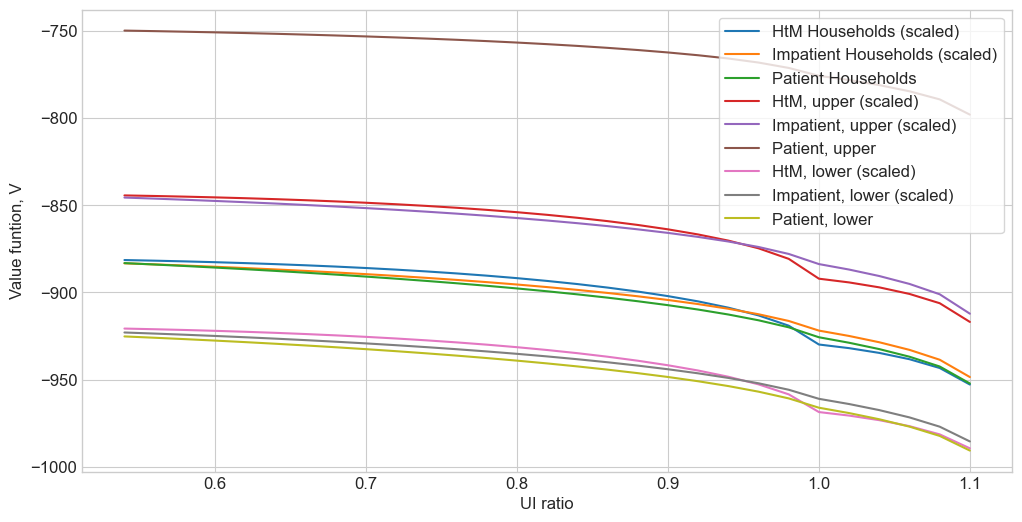

In [45]:
# Depict Value functions

fig = plt.figure(figsize=(12,6),dpi=100)
ax = fig.add_subplot(1,1,1)

ax.plot(UI_ratio_vec, V_UI[:,0]*580, label = f'HtM Households (scaled)' )
ax.plot(UI_ratio_vec, V_UI[:,1]*2, label = f'Impatient Households (scaled)')
ax.plot(UI_ratio_vec, V_UI[:,2], label = f'Patient Households')

ax.plot(UI_ratio_vec, V_UI_upper[:,0]*580, label = f'HtM, upper (scaled)' )
ax.plot(UI_ratio_vec, V_UI_upper[:,1]*2, label = f'Impatient, upper (scaled)')
ax.plot(UI_ratio_vec, V_UI_upper[:,2], label = f'Patient, upper')

ax.plot(UI_ratio_vec, V_UI_lower[:,0]*580, label = f'HtM, lower (scaled)' )
ax.plot(UI_ratio_vec, V_UI_lower[:,1]*2, label = f'Impatient, lower (scaled)')
ax.plot(UI_ratio_vec, V_UI_lower[:,2], label = f'Patient, lower')

ax.legend(frameon = True)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Value funtion, V')

Text(0, 0.5, 'Fraction of population')

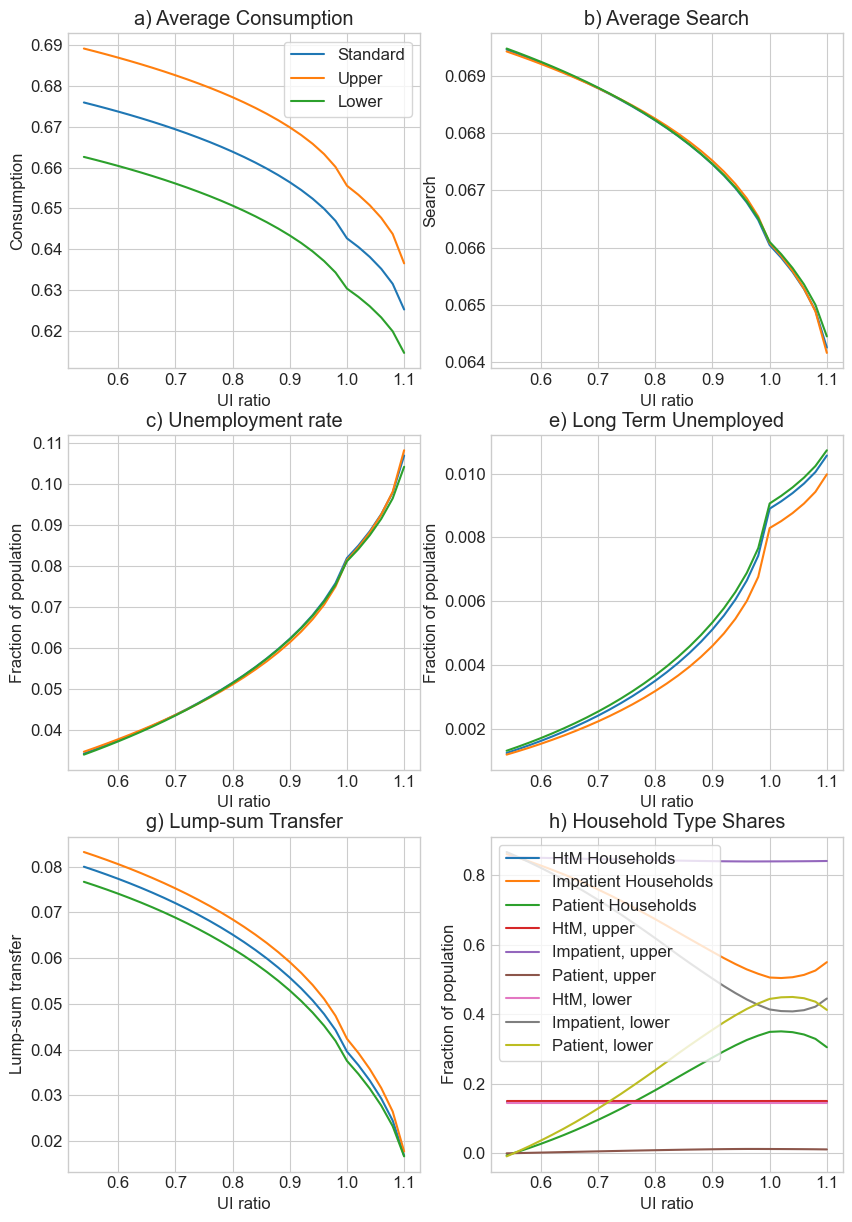

In [55]:
# Depict aggregates

fig = plt.figure(figsize=(10,20),dpi=100)

r = 4

# a. Aggregate Consumption
ax = fig.add_subplot(r,2,1)
ax.set_title(f'a) Average Consumption')


ax.plot(UI_ratio_vec, C_UI, label = f'Standard')
ax.plot(UI_ratio_vec, C_UI_upper, label = f'Upper')
ax.plot(UI_ratio_vec, C_UI_lower, label = f'Lower')



ax.legend(frameon = True)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Consumption')

# b. Aggregate Search
ax = fig.add_subplot(r,2,2)
ax.set_title(f'b) Average Search')

ax.plot(UI_ratio_vec, S_UI, label = f'Total population')
ax.plot(UI_ratio_vec, S_UI_upper, label = f'Total population')
ax.plot(UI_ratio_vec, S_UI_lower, label = f'Total population')



ax.set_xlabel('UI ratio')
ax.set_ylabel('Search')

# c. Unemployment rate
ax = fig.add_subplot(r,2,3)
ax.set_title(f'c) Unemployment rate')

ax.plot(UI_ratio_vec, u_UI, label = f'Total population')
ax.plot(UI_ratio_vec, u_UI_upper, label = f'Total population')

ax.plot(UI_ratio_vec, u_UI_lower, label = f'Total population')



ax.set_xlabel('UI ratio')
ax.set_ylabel('Fraction of population')

# e. Long-term unemployed
ax = fig.add_subplot(r,2,4)
ax.set_title(f'e) Long Term Unemployed')

ax.plot(UI_ratio_vec, u_UI - u_UI_UI, label = f'Total population')
ax.plot(UI_ratio_vec, u_UI_upper - u_UI_UI_upper, label = f'Total population')
ax.plot(UI_ratio_vec, u_UI_lower - u_UI_UI_lower, label = f'Total population')


ax.set_xlabel('UI ratio')
ax.set_ylabel('Fraction of population')

# g. Lump-sum Transfers
ax = fig.add_subplot(r,2,5)
ax.set_title(f'g) Lump-sum Transfer')

ax.plot(UI_ratio_vec, L_UI)
ax.plot(UI_ratio_vec, L_UI_upper)
ax.plot(UI_ratio_vec, L_UI_lower)


ax.set_xlabel('UI ratio')
ax.set_ylabel('Lump-sum transfer')

# h. Type fractions
ax = fig.add_subplot(r,2,6)
ax.set_title(f'h) Household Type Shares')

ax.plot(UI_ratio_vec, betashare_UI[:,0], label = f'HtM Households')
ax.plot(UI_ratio_vec, betashare_UI[:,1], label = f'Impatient Households')
ax.plot(UI_ratio_vec, betashare_UI[:,2], label = f'Patient Households')

ax.plot(UI_ratio_vec, betashare_UI_upper[:,0], label = f'HtM, upper')
ax.plot(UI_ratio_vec, betashare_UI_upper[:,1], label = f'Impatient, upper')
ax.plot(UI_ratio_vec, betashare_UI_upper[:,2], label = f'Patient, upper')

ax.plot(UI_ratio_vec, betashare_UI_lower[:,0], label = f'HtM, lower')
ax.plot(UI_ratio_vec, betashare_UI_lower[:,1], label = f'Impatient, lower')
ax.plot(UI_ratio_vec, betashare_UI_lower[:,2], label = f'Patient, lower')

ax.legend(frameon = True)

        
ax.set_xlabel('UI ratio')
ax.set_ylabel('Fraction of population')

Text(0, 0.5, 'Gini Coefficient')

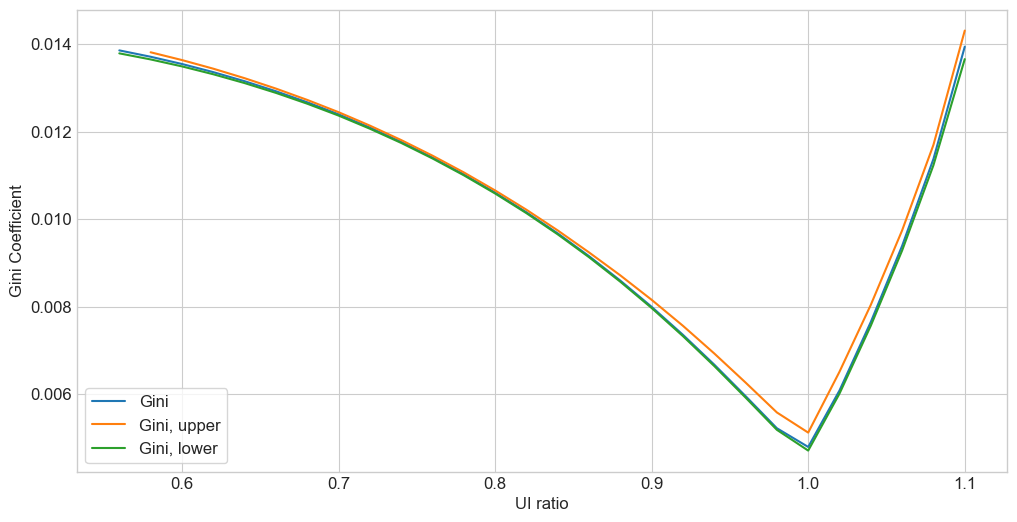

In [53]:
# Depict Gini Coefficients

for i in range(len(UI_ratio_vec)):
    if gini_UI[i] > 0 and gini_UI[i-1] == 0:
        break
    else:
        i = 0

for j in range(len(UI_ratio_vec)):
    if gini_UI_upper[j] > 0 and gini_UI_upper[j-1] == 0:
        break
    else:
        j = 0

for k in range(len(UI_ratio_vec)):
    if gini_UI_lower[k] > 0 and gini_UI_lower[k-1] == 0:
        break
    else:
        k = 0
        
fig = plt.figure(figsize=(12,6),dpi=100)
ax = fig.add_subplot(1,1,1)

ax.plot(UI_ratio_vec[i:], gini_UI[i:], label = 'Gini')
ax.plot(UI_ratio_vec[j:], gini_UI_upper[j:], label = 'Gini, upper')
ax.plot(UI_ratio_vec[k:], gini_UI_lower[k:], label = 'Gini, lower')

        
ax.legend(frameon = True)

ax.set_xlabel('UI ratio')
ax.set_ylabel('Gini Coefficient')